In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.preprocessing import SNV, MSC, SavitzkyGolay, Detrend
from pptoolbox.visualization import (plot_spectra, plot_loadings, plot_scree, fit_pca,
                                               generate_pc_df, plot_svp, initialize_theme)

from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

import glob
import pickle

from pptoolbox.visualization import initialize_theme
cmaps = initialize_theme()

In [26]:
label_df = pd.read_csv('../data/processed/label_df_250204.csv')
label_df.head()

,lot_id,lot_name,Brix,T440,T625,TTA,Turbidity,train_test
0,89669,GR 23645201,70.54,87.5,99.8,2.46,0.0,test
1,89670,GR 23645401,70.55,87.5,99.9,2.44,0.0,train
2,89671,GR 23694601,70.72,84.5,96.4,2.43,0.0,train
3,89672,GR 24188801,70.46,86.7,99.9,2.44,0.0,train
4,89673,GR 23444001,70.78,86.9,99.9,2.38,0.0,train


In [27]:
properties_to_compare = list(label_df.select_dtypes(include=[np.number]).columns.drop('lot_id'))
# properties_to_compare.remove('Patulin')
properties_to_compare

['Brix', 'T440', 'T625', 'TTA', 'Turbidity']

In [28]:
# get names of folders in models directory
models = glob.glob('../models/platform/*')
models

#get last part of file path for model name
model_names = [model.split('\\')[-1] for model in models]
model_names

['6547', '6548']

In [29]:
pkl_files = {}
for model_name in model_names:
    print(model_name)
    pkl_files = {
        **pkl_files,
        model_name : {}
    }
    for property_to_compare in properties_to_compare:
        files = glob.glob(f'../models/platform/{model_name}/prediction/trainer_{property_to_compare}.pkl')
        file_path = files[0] if files else None

        pkl_files[model_name] = {
            **pkl_files[model_name],
            f'{property_to_compare}_model' : pickle.load(open(file_path, 'rb')) if file_path else None,
        }

pkl_files

6547
6548


{'6547': {'Brix_model': AutoML v4: SG2D-Scaler-PLS,
  'T440_model': AutoML v4: SNV-Scaler-BayesianRidge,
  'T625_model': AutoML v4: SNV-Scaler-PCA-SVR,
  'TTA_model': AutoML v4: SNV-Scaler-BayesianRidge,
  'Turbidity_model': AutoML v4: SG2D-Scaler-PCA-SGD},
 '6548': {'Brix_model': AutoML v4: SNV-SG2D-Scaler-PLS,
  'T440_model': AutoML v4: SG1D-Scaler-PLS,
  'T625_model': AutoML v4: SNV-Scaler-PCA-Paggro,
  'TTA_model': AutoML v4: SNV-Scaler-Paggro,
  'Turbidity_model': AutoML v4: SG2D-Scaler-PCA-Lars}}

In [30]:
model_pkl_files = {}
for model_name in model_names:
    model_pkl_files = {
        **model_pkl_files,
        model_name : {}
    }
    for property_to_compare in properties_to_compare:
        print(model_name, property_to_compare)
        files = glob.glob(f'../models/platform/{model_name}/prediction/tasteprofile_model_{property_to_compare}.pkl')
        file_path = files[0] if files else None

        model_pkl_files[model_name] = {
            **model_pkl_files[model_name],
            f'{property_to_compare}_model' : pickle.load(open(file_path, 'rb')) if file_path else None,
        }

        display(model_pkl_files[model_name][f'{property_to_compare}_model'])

6547 Brix


Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=15)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(n_components=11, scale=False))])

6547 T440


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('BayesianRidge',
                 BayesianRidge(alpha_1=56300.27671717498,
                               alpha_2=56300.27671717498,
                               lambda_1=24.166882897605,
                               lambda_2=24.166882897605))])

6547 T625


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=4, random_state=42)),
                ('SVR', SVR(C=38.75144945563976, kernel='linear'))])

6547 TTA


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('BayesianRidge',
                 BayesianRidge(alpha_1=1.1837561727069024,
                               alpha_2=1.1837561727069024,
                               lambda_1=288.3528810362053,
                               lambda_2=288.3528810362053))])

6547 Turbidity


Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=7)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=8, random_state=42)),
                ('SGD',
                 SGDRegressor(alpha=33.215130198639045, early_stopping=True,
                              l1_ratio=0.35538987148171053, n_iter_no_change=97,
                              penalty='elasticnet', random_state=42,
                              shuffle=False))])

6548 Brix


Pipeline(steps=[('SNV', SNV()), ('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(n_components=13, scale=False))])

6548 T440


Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=11)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(scale=False))])

6548 T625


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=8, random_state=42)),
                ('Paggro',
                 PassiveAggressiveRegressor(C=0.015810973510234,
                                            early_stopping=True,
                                            n_iter_no_change=7, random_state=42,
                                            shuffle=False))])

6548 TTA


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('Paggro',
                 PassiveAggressiveRegressor(C=0.022676502438312377,
                                            early_stopping=True,
                                            n_iter_no_change=48,
                                            random_state=42, shuffle=False))])

6548 Turbidity


Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=31, random_state=42)),
                ('Lars', Lars(random_state=42))])

In [31]:
MAE_compiled = pd.DataFrame()

for model_name in model_names:
    for property_to_compare in properties_to_compare:
        model = pkl_files[model_name][f'{property_to_compare}_model'] if pkl_files[model_name][f'{property_to_compare}_model'] else None

        MAE = abs(model.get_best_trial()['result']['cv_results']['test_neg_mean_absolute_error']) if model else None
        R2 = model.get_best_trial()['result']['cv_results']['test_r2'] if model else None
        max_error = model.get_best_trial()['result']['cv_results']['test_max_error'] if model else None
        MAE_compiled = MAE_compiled.append({
            'model_name' : model_name,
            'property_to_compare' : property_to_compare,
            'R2' : R2,
            'MAE' : MAE,
            'max_error' : max_error
        }, ignore_index=True)

MAE_compiled

,model_name,property_to_compare,R2,MAE,max_error
0,6547,Brix,0.329689,0.170803,0.328895
1,6547,T440,0.837174,1.482221,3.872139
2,6547,T625,0.228089,0.413886,2.009984
3,6547,TTA,0.123466,0.041178,0.101895
4,6547,Turbidity,-0.059501,0.712232,1.424403
5,6548,Brix,0.315433,0.156941,0.397189
6,6548,T440,0.705965,1.501539,4.212417
7,6548,T625,0.308529,0.369311,1.431118
8,6548,TTA,0.013141,0.041827,0.093835
9,6548,Turbidity,0.008885,0.592265,1.574631


In [32]:
#import training data
training_data = {}
for model_name in model_names:
    files = glob.glob(f'../models/platform/{model_name}/label.csv')
    file_path = files[0] if files else None

    training_data = {
        **training_data,
        model_name : pd.read_csv(file_path) if file_path else None,
    }

training_data


{'6547':     lot_id   TTA   Brix  Turbidity   T625  T440
 0    89671  2.43  70.72          0   96.4  84.5
 1    89672  2.44  70.46          0   99.9  86.7
 2    89675  2.43  70.48          0  100.0  87.9
 3    89676  2.46  70.70          1   99.9  87.5
 4    89677  2.46  70.76          0   99.8  87.6
 5    89678  2.44  70.60          0   99.7  87.0
 6    89679  2.37  70.60          1   99.5  86.8
 7    89680  2.44  70.40          3  100.0  86.5
 8    89681  2.40  70.64          1   99.4  86.7
 9    89690  2.40  70.39          0   99.8  90.1
 10   89692  2.51  70.31          0   99.7  88.8
 11   89694  2.37  70.67          0   97.6  87.1
 12   89695  2.37  70.26          0  100.0  86.8
 13   89697  2.47  70.29          0   98.9  72.1
 14   89703  2.40  70.30          0   99.5  85.9
 15   89745  2.38  70.34          0  100.0  87.1
 16   89747  2.50  70.10          0   99.6  88.9
 17   89748  2.54  70.10          0  100.0  88.3
 18   89755  2.53  70.72          1   97.5  70.4
 19   89759 

In [33]:
#obtain range of values of each property in training data
property_ranges = {}
for model_name in model_names:
    property_ranges = {
        **property_ranges,
        model_name : {}
    }
    for property_to_compare in properties_to_compare:
        property_ranges[model_name][property_to_compare] = training_data[model_name][property_to_compare].max() - training_data[model_name][property_to_compare].min()

property_ranges['full_range'] = {}
for property_to_compare in properties_to_compare:
    property_ranges['full_range'][property_to_compare] = label_df[property_to_compare].max() - label_df[property_to_compare].min()

In [34]:
property_ranges

{'6547': {'Brix': 0.8599999999999994,
  'T440': 21.299999999999997,
  'T625': 3.5999999999999943,
  'TTA': 0.2400000000000002,
  'Turbidity': 3},
 '6548': {'Brix': 0.8599999999999994,
  'T440': 21.299999999999997,
  'T625': 3.5999999999999943,
  'TTA': 0.2400000000000002,
  'Turbidity': 3},
 'full_range': {'Brix': 0.8599999999999994,
  'T440': 21.299999999999997,
  'T625': 3.5999999999999943,
  'TTA': 0.2400000000000002,
  'Turbidity': 3.0}}

In [35]:
MAE_compiled = MAE_compiled.dropna()
# add on property ranges, mapping to model name
MAE_compiled['6547_range'] = MAE_compiled['property_to_compare'].map(lambda x: property_ranges['6547'][x])
MAE_compiled['6548_range'] = MAE_compiled['property_to_compare'].map(lambda x: property_ranges['6548'][x])


#combine 6547 and 6548 range into current range based on matching model name
MAE_compiled['current_range'] = MAE_compiled.apply(lambda x: x['6547_range'] if '6547' in x['model_name'] else x['6548_range'], axis=1)

MAE_compiled['full_range'] = MAE_compiled['property_to_compare'].map(lambda x: property_ranges['full_range'][x])

#drop 6547 and 6548 range columns
MAE_compiled.drop(columns=['6547_range', '6548_range'], inplace=True)

MAE_compiled['MAE_current_range_pct'] = MAE_compiled['MAE'] / MAE_compiled['current_range'] * 100
MAE_compiled['MAE_full_range_pct'] = MAE_compiled['MAE'] / MAE_compiled['full_range'] * 100

# map 6547 to AJC 50 lots, 6548 to AJC 50 lots in model names
MAE_compiled['model_name'] = MAE_compiled['model_name'].map(lambda x: 'AJC clear 30 lots' if '6547' in x else 'AJC clear 40 lots')

MAE_compiled

,model_name,property_to_compare,R2,MAE,max_error,current_range,full_range,MAE_current_range_pct,MAE_full_range_pct
0,AJC clear 30 lots,Brix,0.329689,0.170803,0.328895,0.86,0.86,19.860840,19.860840
1,AJC clear 30 lots,T440,0.837174,1.482221,3.872139,21.30,21.30,6.958782,6.958782
2,AJC clear 30 lots,T625,0.228089,0.413886,2.009984,3.60,3.60,11.496827,11.496827
3,AJC clear 30 lots,TTA,0.123466,0.041178,0.101895,0.24,0.24,17.157609,17.157609
4,AJC clear 30 lots,Turbidity,-0.059501,0.712232,1.424403,3.00,3.00,23.741074,23.741074
5,AJC clear 40 lots,Brix,0.315433,0.156941,0.397189,0.86,0.86,18.248969,18.248969
6,AJC clear 40 lots,T440,0.705965,1.501539,4.212417,21.30,21.30,7.049481,7.049481
7,AJC clear 40 lots,T625,0.308529,0.369311,1.431118,3.60,3.60,10.258632,10.258632
8,AJC clear 40 lots,TTA,0.013141,0.041827,0.093835,0.24,0.24,17.428054,17.428054
9,AJC clear 40 lots,Turbidity,0.008885,0.592265,1.574631,3.00,3.00,19.742168,19.742168


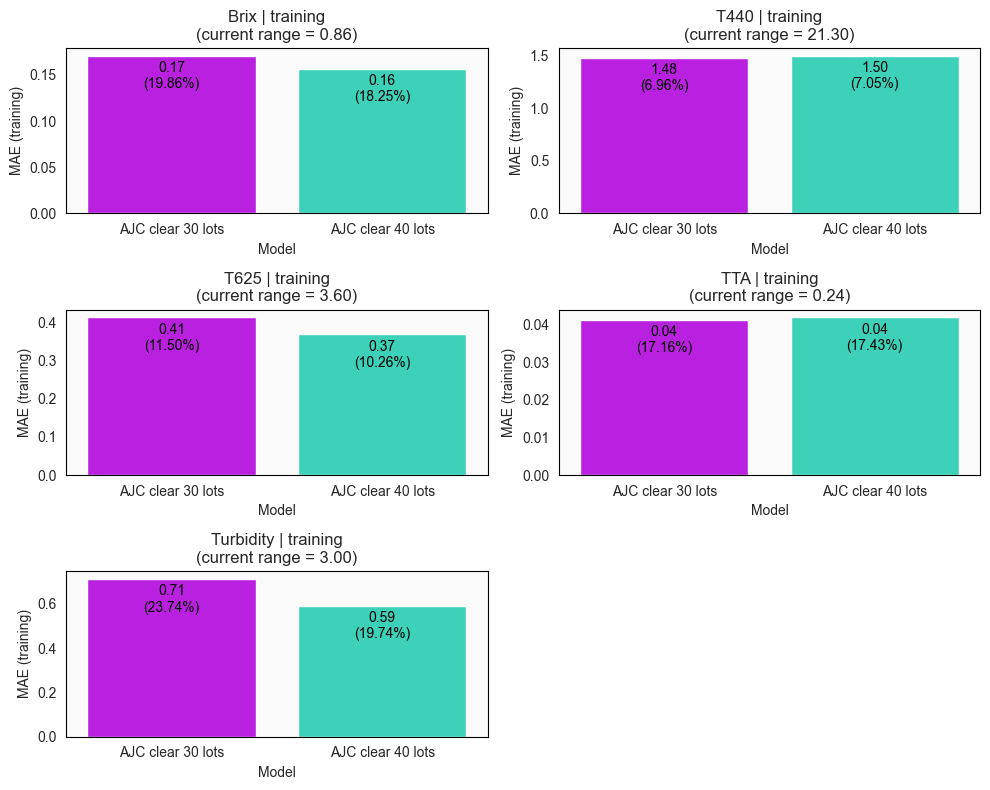

In [36]:
# Get unique properties
properties = MAE_compiled['property_to_compare'].unique()
num_properties = len(properties)

rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each property in a separate subplot
for i, prop in enumerate(properties):
    ax = axes[i]
    sns.barplot(data=MAE_compiled[MAE_compiled['property_to_compare'] == prop], 
                x='model_name', y='MAE', ax=ax)
    ax.set_title(f'{prop} | training\n(current range = {property_ranges["full_range"][prop]:.2f})')
    # ax.set_title(f'{prop}')
    ax.set_xlabel("Model")
    ax.set_ylabel("MAE (training)")

    # add labels to the bars
    mae_range = MAE_compiled[MAE_compiled['property_to_compare'] == prop]['MAE_full_range_pct'].values

    for i, value in enumerate(MAE_compiled[MAE_compiled['property_to_compare'] == prop]['MAE']):
        ax.text(i, value - max(MAE_compiled[MAE_compiled['property_to_compare'] == prop]['MAE'])*0.0333, 
                f'{value:.2f}\n({mae_range[i]:.2f}%)', 
                color='black', ha='center', va='top')
#remove empty subplots
for i in range(num_properties, rows*cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()